# TLDR

Special thanks to my dear friends [Julius](https://github.com/jul1u5) and [Laurynas](https://github.com/laurislopata) who joined me to work on this project.

We worked on and off for more than a month on this project, and I must say that it was not an easy, but definitely an extremely rewarding experience considering how much I've learnt. It was also a good chance to hone my problem solving skills and endurance, as we switched approaches (and even libraries!) at least three times, spent substantial amounts of time reading through various resources and codebases and trying to adapt the codes to our purpose through trial and error.

**The key takeaways are:**

1. **Do not ever use old captchas** and encourage others not to, as there are too many ways to break them nowadays.
2. Fastai has a **great mid-level API** that allows for customization for almost any use, but getting the hang of it might be tricky. Here are some resources that tremendously helped us:
    - Looking at fastai [docs and tutorials](https://docs.fast.ai/) and reading through source code
    - [A walk with fastai2](https://www.youtube.com/playlist?list=PLFDkaGxp5BXDvj3oHoKDgEcH73Aze-eET) playlist that has excellent material on using the fastai mid-level API
    - [fastai v2 walk-thru](https://www.youtube.com/playlist?list=PLfYUBJiXbdtSWRCYUHh-ThVCC39bp5yiq) playlist on YouTube where Jeremy Howard talks how and why the library is built the way it is
3. **Perseverance is key** - great ideas and solutions usually do not come overnight, but breaking the problem into smaller pieces and continously improving on each of those is a good way to go.

# Introduction

The idea is to use deep learning to recognise images from [this](https://github.com/PacktPublishing/Machine-Learning-for-Cybersecurity-Cookbook/blob/master/Chapter05/CAPTCHA%20Breaker/captcha_images.7z) captcha image dataset. The images look like the following:

![](captcha-example.png "Example captcha image")

Our final approach was the following:

1. Create a data loader that would load in an image and a length four tensor that would represent the encoded symbol at each position in the captcha
2. Create a multi-output model that would output a 128 length tensor and then reshape it to a 32x4 tensor
    - The output is 32x4 because there are 32 possible letters (the dataset that we used had no `0`, `1`, `O` or `I`) for each position, i.e. model has four outputs, each predicting one of the 32 symbols for each position in the captcha
3. Use `CrossEntropyLoss` with `reduction="sum"` which will calculate the losses for each of the four outputs and sum them up. This way, we can easily build a model to predict multiple things at the same time

Everything looked rather easy at first, however, it took us quite some time to come up with an elegant and easy to follow implementation. Continue reading for details!

# Imports

Toggle cells below if you want to see what imports are being made.

In [1]:
#|code-fold: true
# Uncomment these and run once if you are using colab
# !pip install -qq torchtext==0.8.1
# !pip install -Uqq fastbook

In [3]:
#|code-fold: true
%load_ext autoreload
%autoreload 2

%matplotlib inline

from fastai.vision.all import *
import PIL

# Data

In [4]:
#|include: false
# Run this once to download the data
# !wget -q --no-check-certificate --content-disposition https://github.com/PacktPublishing/Machine-Learning-for-Cybersecurity-Cookbook/blob/master/Chapter05/CAPTCHA%20Breaker/captcha_images.7z?raw=true

In [5]:
#|include: false
# Run this once to unzip the data
# !7z x captcha_images.7z

In [6]:
#|include: false
# Check that everything is as it should be
!ls captcha_images | wc

   9955    9955   89595


Use fastai `get_image_files` utility function to get a list of paths to captcha files:

In [7]:
PATH = Path("captcha_images")
files = get_image_files(PATH)
files[0]

Path('captcha_images/PRBV.png')

We separately checked that all the images are 24x72x3.

Create python dictionaries that will be used to map symbols to integers and vice versa:

In [8]:

# Find all the unique labels
ld = set()
for f in files:
    for l in f.stem:
        ld.add(l)

label_mapper = "".join(sorted(ld))
l2i = { label_mapper[i]: i for i in range(len(label_mapper)) } # labels to int
i2l = { v: k for k, v in l2i.items() } # int to labels

# Dataset

This custom thing that we need is a fastai `Transform` that knows how to deal with a multi-output label. Reading through fastai source code we've managed to find that a convenient way to do this is to create a class that inherits from `DisplayedTransform`. The attributes `l2i` and `i2l` are used for label to int mapping. The `encodes` method is how to tell the library how something should be encoded, here we just take a string type label and turn it into a `TensorCategory` which is nothing more but a length four tensor with the name given for it to have a more human-readable semantic meaning. Similarly, the `decodes` method takes an encoded label and reverses it back to a string label which is wrapped in the `Category` class that is intended for categories that will be shown somewhere, e.g. in plots.

In [9]:
class MultiOutputCategorize(DisplayedTransform):
    def __init__(self, l2i=l2i, i2l=i2l):
        self.l2i = l2i
        self.i2l = i2l

    def encodes(self, string_label):
        return TensorCategory([self.l2i[l] for l in string_label])

    def decodes(self, encoded_label):
        return Category("".join([self.i2l[v.item()] for v in encoded_label]))

We can now use our new transform to create a `DataBlock`, the cornerstone of fastai's mid-level API that is very flexible and can be customized for various purposes (a good example is [this](https://docs.fast.ai/tutorial.siamese.html) where it is used to implement a siamese network).

Important thing to notice is how we wrap our `MultiOutputCategorize` in a `TransformBlock`.

We also use augmentations to have more variety in our data while training the model. `CropPad` is used to pad image to a square (remember that all images were 24x72). All the other transform are pretty self explanatory, but make sure you read about them in the fastai docs if you feel like you need to.

In [10]:
captcha_data_block = DataBlock(
    blocks=(ImageBlock, TransformBlock(type_tfms=MultiOutputCategorize())),
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=lambda x: x.stem,
    item_tfms=[CropPad(size=72, pad_mode=PadMode.Border), Resize(64)],
    batch_tfms=[*aug_transforms(do_flip=False, max_rotate=5.0)],
)

Now create a dataloader, we use batch size 128 since experiments showed that it was the optimal one:

In [11]:
dls = captcha_data_block.dataloaders(files, bs=128, num_workers=4, shuffle=True)
dls = dls.cuda()

Another important thing to note is how fastai handles types behind the scenes - even though the images and labels were transformed and their actual types changed, the library manages to bubble up the correct initial types if needed. One of the authors of the library Jeremy Howard mentions in his code walk-thrus on YouTube that such an approach was borrowed from other programming languages that he used.

In [12]:
dls._types

{tuple: [fastai.torch_core.TensorImage, fastai.torch_core.TensorCategory]}

Let's just one batch to make sure everything is alright:

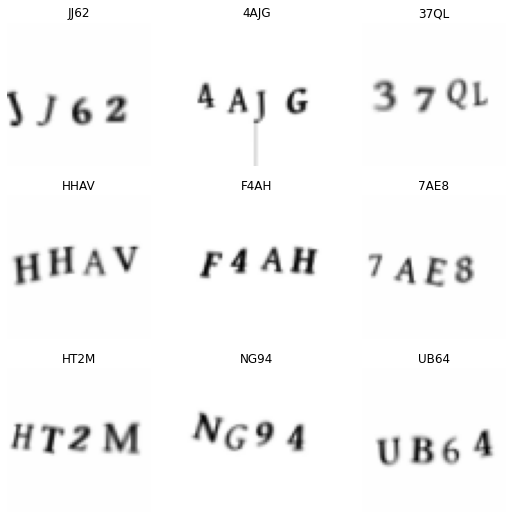

In [13]:
dls.show_batch()

Also check that our custom transform is working as it should be:

In [14]:
b = dls.one_batch()
b[1][0]

TensorCategory([ 9, 19,  0, 15], device='cuda:0')

# Model

It is now time to build our multi-output model. Let's begin by creating the final layer that will just take the outputs and will reshape them to 32x4 (ignoring batch dimension)

In [15]:
N_OUTPUTS = 4

class ReshapeLayer(nn.Module):
    def __init__(self, n_classes=len(l2i), n_outputs=N_OUTPUTS):
        super().__init__()
        self.n_classes = n_classes
        self.n_outputs = n_outputs
    
    def forward(self, out):
        out = out.reshape(-1, self.n_classes, self.n_outputs)

        return out

Next, we use fastai's `create_body` method to get a `resnet18` model backbone pretrained on ImageNet data. We then use the `create_head` method to add a head mainly consisting of fully-connected layers to map the outputs from the convolutional backbone to a `32*4=128` length vector. The weird parameter `body[-1][-1].bn2.num_features` is actually equal to `512` and is just the number of outputs of the convolutional backbone. We found that the model does not overfit so we turn off dropout by setting `ps=0.0`:

In [16]:
body = create_body(resnet18, cut=-2, pretrained=True)
head = create_head(body[-1][-1].bn2.num_features, N_OUTPUTS * len(l2i), ps=0.0)

Combine the `body`, the `head` and the `ReshapeLayer` into a final model:

In [17]:
model = nn.Sequential(
    body,
    head,
    ReshapeLayer(n_classes=len(l2i), n_outputs=N_OUTPUTS),
    # output will be [bs, num_classes=32, n_outputs=4]
)
model = model.cuda()

This last line that casts to model to the GPU might be redundant, but we haven't checked that, so for now it is better to be safe than sorry.

Finally create a function that will tell how the model's parameters have to be split when we'll use transfer learning (e.g. which parts should be frozen or not):

In [18]:
def model_splitter(model):
    return [params(model[0]), params(model[1:])]

# Training

We have come up to training the model.

First we need some custom functions that will track our metrics. The first one calculates overall accuracy (fraction of images were the model gets **all** four outputs right) and the second one calculates the fraction of individual outputs that the model got right. For example, for captcha "ABCD", if the model guesses "ABCA", then the overall accuracy will be 0, but individual accuracy will be 75% (3 out of 4 letters guessed correctly):

In [19]:
def multi_output_accuracy(inp, targ):
    labels_pred = torch.softmax(inp, dim=1)
    labels_pred = torch.argmax(labels_pred, dim=1)

    return ((labels_pred == targ).all(dim=1)).sum() / inp.size(0)

In [20]:
def multi_output_individual_accuracy(inp, targ):
    labels_pred = torch.softmax(inp, dim=1)
    labels_pred = torch.argmax(labels_pred, dim=1)

    return (labels_pred == targ).sum() / (inp.size(0) * targ.size(1))

Next, we create a custom `MultiOutputCrossEntropyLoss` which is an adaption of fastai's `CrossEntropyLossFlat` for our multi-output needs.

Figuring out the details of this one took a substantial amount of time, but in the end we figured out what each of the parameters do:
- setting `flatten=False` turns off the default output flattening which is what we want
- `reduction="sum"` makes the loss functions sum up the losses of individual outputs instead of averaging them
- `axis=1` tells the loss function that softmax and argmax should operate on dim=1, in our case this means that we go from shape [bs, num_classes=32, n_output=4] to shape [bs, n_output=4] after those activations are applied which is exactly what we want

Finally, we override the `__call__` method because we noticed that the output gets weirdly transposed internally, so adding an additional transpose here reverses it and makes things work the way they should be: 

In [21]:
class MultiOutputCrossEntropyLoss(CrossEntropyLossFlat):
    def __init__(self, *args, **kwargs):
        super().__init__(flatten=False, reduction="sum", axis=1, *args, **kwargs)
    
    def __call__(self, inp, targ, **kwargs):
        # fastai does an extra transpose inside, but we do need it, so this reverses it
        inp = inp.transpose(1, 2)
        return super().__call__(inp, targ, **kwargs)

Now assemble all the bits from above to create a fastai learner:

In [22]:
learn = Learner(dls, model, loss_func=MultiOutputCrossEntropyLoss(), metrics=[multi_output_accuracy, multi_output_individual_accuracy], splitter=model_splitter)

In [23]:
#|include: false
# Could try to use `learn.fine_tune`

We want to start by only training the head for a little bit, so let's freeze the convolutional backbone:

In [24]:
learn.freeze()

Look for a suitable learning rate:

SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=0.007585775572806597)

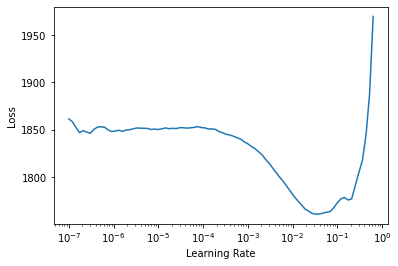

In [25]:
learn.lr_find()

Train the head for 2 epochs with the found learning rate:

In [26]:
learn.fit_one_cycle(2, 5e-3)

epoch,train_loss,valid_loss,multi_output_accuracy,multi_output_individual_accuracy,time
0,1531.273804,1531.483521,0.000000,0.170517,00:17
1,1195.153687,1006.178101,0.017077,0.400804,00:16


Unfreeze the convolutional backbone:

In [27]:
learn.unfreeze()

Look for a good learning rate and then train the whole model for 3 epochs:

SuggestedLRs(lr_min=0.002754228748381138, lr_steep=0.005248074419796467)

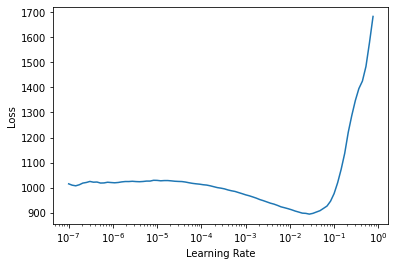

In [28]:
learn.lr_find()

In [29]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,multi_output_accuracy,multi_output_individual_accuracy,time
0,611.221069,1285.856934,0.011552,0.353717,00:17
1,227.990952,82.341156,0.817177,0.950778,00:17
2,79.013634,9.029308,0.993973,0.998493,00:17


Look for a learning rate again (we will find it is a much smaller one) and train the model for one more epoch to get those extra bits of accuracy:

SuggestedLRs(lr_min=0.00043651582673192023, lr_steep=6.309573450380412e-07)

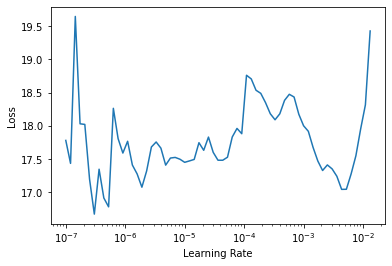

In [30]:
learn.lr_find()

In [31]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,multi_output_accuracy,multi_output_individual_accuracy,time
0,15.953323,7.600945,0.997991,0.999498,00:17


In just 6 epochs, transfer learning allowed us to reach we managed toan accuracy of 99.7% percent. Amazing!

In [32]:
#|include: false
learn.save("captcha-model")

Path('models/captcha-model.pth')

# Testing

## Check validation set results

Check the model's performance on a batch of data:

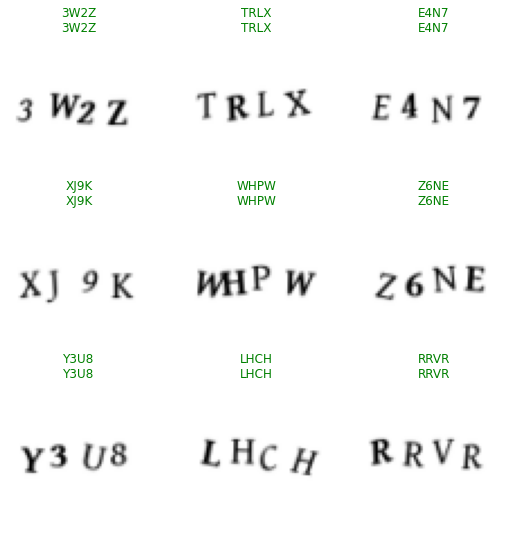

In [42]:
learn.show_results()

## Get failed captchas

Get predictions:

In [43]:
inputs, _, targets, decoded_preds = learn.get_preds(with_input=True, with_decoded=True)
inputs.size(), targets.size(), decoded_preds.size()

(torch.Size([1991, 3, 64, 64]), torch.Size([1991, 4]), torch.Size([1991, 4]))

Indices of failed captchas are:

In [44]:
failed_idxs = (~(decoded_preds == targets).all(dim=1)).nonzero().view(-1)

Show those captchas to check why the model failed:

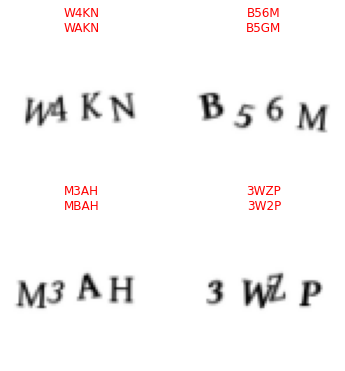

In [45]:
dls.show_results(b=(inputs[failed_idxs], targets[failed_idxs]), out=decoded_preds[failed_idxs])

We can see that the model does some slight errors, but it only fails on 4 captchas out of a validation set of 1991 images which is an amazing result. I hope that it is now obvious that using captchas to protect a website from bots is not a good idea.

Check the model's confidence when it makes errors:

In [46]:
for idx in failed_idxs.detach().cpu().numpy().flatten():
    decoded_pred, pred, model_output = learn.predict(dls.valid_ds[idx][0])
    probs = torch.softmax(model_output, dim=0)[pred].diag()
    print(f"Actual: {''.join([i2l[v.item()] for v in dls.valid_ds[idx][1]])}, predicted: {decoded_pred}, probs: {probs}")

Actual: W4KN, predicted: WAKN, probs: tensor([0.0805, 0.0574, 0.0800, 0.0804])


Actual: B56M, predicted: B5GM, probs: tensor([0.0775, 0.0805, 0.0517, 0.0805])


Actual: M3AH, predicted: MBAH, probs: tensor([0.0805, 0.0492, 0.0803, 0.0805])


Actual: 3WZP, predicted: 3W2P, probs: tensor([0.0805, 0.0795, 0.0597, 0.0804])


> Note: In each case the probabilities for the failed letters were **lower**.

In [47]:
#|include: false
# Check a random image
idx = np.random.randint(len(files))
pred = learn.predict(files[idx])[0]
files[idx].stem, pred

('WP5D', 'WP5D')

# Conclusion

We have successfully managed to use the fastai's mid-level API to build a multi-output model in an elegant and understandable way with virtually any workarounds.

Note that here we have used a relatively easy dataset of captchas, but we are convinced that the same approach would deliver similar results even on harder datasets (say one that would be RGB colour instead of black and white and with some noise added in). 

Feel free to open the code and play around with it and maybe adapt for your own projects.

Thank you for reading all the way through! Please, if you have any questions or suggestions on how I could improve, leave them down below in the comments.